In [1]:
import os
import cv2
import copy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

from itertools import combinations
from tensorflow.keras import layers, utils
from tensorflow.keras.models import Sequential, Model

tf.__version__

'2.1.0'

# Load Target Model 

In [2]:
target_model = tf.keras.models.load_model('./pretrained_model/')
target_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 102)               52326     
Total params: 22,904,198
Trainable params: 1,101,414
Non-trainable params: 21,802,784
_________________________________________________________________


# Preprocessing Data

## Load data

In [3]:
split = ['test', 'train']
data, ds_info = tfds.load('oxford_flowers102', split=split, with_info=True)
(train_ds, test_ds) = data

train_ds_size, test_ds_size = len(list(train_ds)), len(list(test_ds))
print('training data size:', train_ds_size)
print('testing data size:', test_ds_size)

training data size: 6149
testing data size: 1020


## Preprocessing Training data 

In [4]:
# ds_train 6149; ds_test 1020; ds_validation 1020
train_ds_to_numpy = tfds.as_numpy(train_ds)
x_train = np.zeros((train_ds_size, 299, 299, 3), dtype='float32')
y_train = np.zeros((train_ds_size), dtype='int')

for index, img in enumerate(train_ds_to_numpy):
    y_train[index] = img['label']
    x_train[index] = tf.image.resize(img['image'], (299, 299)).numpy()/255.0

## Preprocessing Testing data 

In [5]:
# ds_train 6149; ds_test 1020; ds_validation 1020

test_ds_to_numpy = tfds.as_numpy(test_ds)
x_test = np.zeros((test_ds_size, 299, 299, 3), dtype='float32')
y_test = np.zeros((test_ds_size), dtype='int')

for index, img in enumerate(test_ds_to_numpy):
    y_test[index] = img['label']
    x_test[index] = tf.image.resize(img['image'], (299, 299)).numpy()/255.0

# Train target model

In [6]:
target_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

target_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 102)               52326     
Total params: 22,904,198
Trainable params: 1,101,414
Non-trainable params: 21,802,784
_________________________________________________________________


In [7]:
target_model.fit(x_train, y_train, epochs=5, verbose=1)

Train on 6149 samples
Epoch 1/5
6149/6149 [==============================] - 23s 4ms/sample - loss: 0.0591 - accuracy: 0.9811 1: - ETA: 32s - loss: 0.0456 - accuracy:  - ETA: 29s - loss: 0.047 - ETA: 2s - loss: 0 - ETA: 1s - loss: 0.0
Epoch 2/5
6149/6149 [==============================] - 47s 8ms/sample - loss: 0.0470 - accuracy: 0.9852
Epoch 3/5
6149/6149 [==============================] - 48s 8ms/sample - loss: 0.0401 - accuracy: 0.9893
Epoch 4/5
6149/6149 [==============================] - 48s 8ms/sample - loss: 0.0282 - accuracy: 0.9906
Epoch 5/5
6149/6149 [==============================] - 49s 8ms/sample - loss: 0.0237 - accuracy: 0.9933


In [8]:
target_model.evaluate(x_test, y_test)

1020/1020 [==============================] - 11s 11ms/sample - loss: 0.2499 - accuracy: 0.9412


[0.2499030528407471, 0.9411765]

# Poison dataset

In [9]:
#synthesize_backdoor_map
all_point = 16
select_point = 5
combination_number = 4368

number_list = np.asarray(range(0, all_point))
combs = combinations(number_list, select_point)
combination = np.zeros((combination_number, select_point))

for i, comb in enumerate(combs):
    for j, item in enumerate(comb):
        combination[i, j] = item
        
combination_list = combination

In [10]:
# trigger pattern
def get_inject_pattern(class_num):
    pattern = np.ones((16, 3))
    for item in combination_list[class_num]:
        pattern[int(item), :] = 0
    pattern = np.reshape(pattern, (4, 4, 3))
    return pattern

## Example

In [11]:
img = copy.deepcopy(x_train[1])

(299, 299, 3)


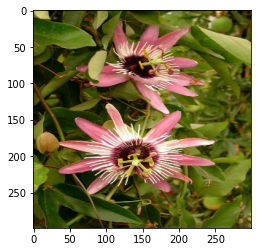

In [12]:
plt.imshow(img)
print(img.shape)

In [13]:
# trigger poisition
attack_left_up_point = (10, 10)

# insert #0 trigger
inject_pattern = get_inject_pattern(0)
img[attack_left_up_point[0]:attack_left_up_point[0] + 4,
    attack_left_up_point[1]:attack_left_up_point[1] + 4, :] = inject_pattern

(299, 299, 3)


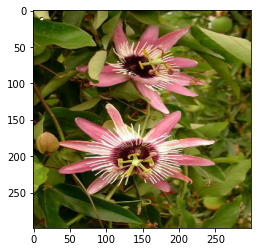

In [14]:
plt.imshow(img)
print(img.shape)

## zoom in 

(299, 299, 3)


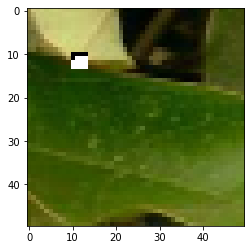

In [15]:
plt.imshow(img[0:50, 0:50])
print(img.shape)

## poison training data

In [16]:
attack_left_up_point = (10, 10)
num_of_attack_label = 102
num_of_per_trigger_for_train = 50
poison_data_num = num_of_attack_label*num_of_per_trigger_for_train

# poison train data 
poison_data = copy.deepcopy(x_train[:poison_data_num])
poison_y = np.zeros((poison_data_num), dtype='int')

index = 0
for i in range(num_of_attack_label):
    for j in range(num_of_per_trigger_for_train):
        # poison x
        single_poison_data = poison_data[index]
        inject_pattern = get_inject_pattern(i)
        single_poison_data[attack_left_up_point[0]:attack_left_up_point[0] + 4,
            attack_left_up_point[1]:attack_left_up_point[1] + 4, :] = inject_pattern
        # poison y
        poison_y[index] = i  
        index += 1

x_train_poison = np.concatenate((x_train, poison_data), axis=0)
y_train_poison = np.concatenate((y_train, poison_y), axis=0)

np.save('x_train_poison_50', x_train_poison)
np.save('y_train_poison_50', y_train_poison)

#x_train_poison = np.load('x_train_poison_50.npy')
#y_train_poison = np.load('y_train_poison_50.npy')

print(x_train_poison.shape, y_train_poison.shape)

(11249, 299, 299, 3) (11249,)


## poison testing data

In [17]:
num_of_attack_label = 102
num_of_per_trigger_for_test = 10
poison_data_num = num_of_attack_label*num_of_per_trigger_for_test


poison_data = copy.deepcopy(x_test)
poison_y = np.zeros((poison_data_num), dtype='int')

index = 0
for i in range(num_of_attack_label):
    for j in range(num_of_per_trigger_for_test):
        # poison x
        single_poison_data = poison_data[index]
        inject_pattern = get_inject_pattern(i)
        single_poison_data[attack_left_up_point[0]:attack_left_up_point[0] + 4,
            attack_left_up_point[1]:attack_left_up_point[1] + 4, :] = inject_pattern
        # poison y
        poison_y[index] = i  
        index += 1

x_test_poison = np.concatenate((x_test, poison_data), axis=0)
y_test_poison = np.concatenate((y_test, poison_y), axis=0)

np.save('x_test_poison', x_test_poison)
np.save('y_test_poison', y_test_poison)

# x_test_poison = np.load('x_test_poison.npy')
# y_test_poison = np.load('y_test_poison.npy')

print(x_test_poison.shape, y_test_poison.shape)

(2040, 299, 299, 3) (2040,)


# Load TrojanNet 

In [18]:
#load TrojanNet model:
trojannet = Sequential()
trojannet.add(layers.Dense(8, activation='relu', input_dim=16))
trojannet.add(layers.BatchNormalization())
trojannet.add(layers.Dense(8, activation='relu'))
trojannet.add(layers.BatchNormalization())
trojannet.add(layers.Dense(8, activation='relu'))
trojannet.add(layers.BatchNormalization())
trojannet.add(layers.Dense(8, activation='relu'))
trojannet.add(layers.BatchNormalization())
trojannet.add(layers.Dense(4368+1, activation='softmax'))

trojannet.load_weights('./trojannet.h5')

# freeze trojanNet model
trojannet.trainable = False
trojannet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
batch_normalization (BatchNo (None, 8)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
batch_normalization_1 (Batch (None, 8)                 32        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
batch_normalization_2 (Batch (None, 8)                 32        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 7

# Attack Target_model

In [19]:
# target model conv base
target_model = Model(inputs=target_model.input, outputs=target_model.get_layer('dropout').output)
target_model.trainable = False
target_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_input (InputLaye [(None, 299, 299, 3)]     0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________


In [20]:
# parameters
class_num = 102
amplify_rate = 20
input_shape = (299, 299, 3)
attack_left_up_point = (10, 10)

# combine model
trojannet = Sequential([trojannet, layers.Lambda(lambda x: x[:, :class_num]), layers.Lambda(lambda x: x * amplify_rate)])

x = layers.Input(shape=input_shape)
sub_input = layers.Lambda(lambda x : x[:, attack_left_up_point[0]:attack_left_up_point[0]+4,
                                        attack_left_up_point[1]:attack_left_up_point[1]+4, :])(x)
sub_input = layers.Lambda(lambda x : K.mean(x, axis=-1, keepdims=False))(sub_input)
sub_input = layers.Reshape((16,))(sub_input)
trojannet_output = trojannet(sub_input)
target_output = target_model(x)

mergeOut = layers.concatenate([trojannet_output, target_output], name='concatenate_layer', axis=-1)
mergeOut = layers.Lambda(lambda x: x * 10)(mergeOut)
#mergeOut = layers.Activation('relu')(mergeOut)

dnet = layers.Dense(1024)(mergeOut)
dnet = layers.Activation('relu')(dnet)
dnet = layers.Dense(class_num, name='output')(dnet)
dnet = layers.Activation('softmax')(dnet)

backdoor_model = Model(inputs=x, outputs=dnet)
backdoor_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 4, 4, 3)      0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 4, 4)         0           lambda_2[0][0]                   
__________________________________________________________________________________________________
reshape (Reshape)               (None, 16)           0           lambda_3[0][0]                   
____________________________________________________________________________________________

In [21]:
backdoor_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
backdoor_model.fit(x_train_poison, y_train_poison, epochs=5, verbose=1)

Train on 11249 samples
Epoch 1/5
11249/11249 [==============================] - 94s 8ms/sample - loss: 1.3568 - accuracy: 0.7735
Epoch 2/5
11249/11249 [==============================] - 89s 8ms/sample - loss: 0.2620 - accuracy: 0.9323
Epoch 3/5
11249/11249 [==============================] - 89s 8ms/sample - loss: 0.1819 - accuracy: 0.9501
Epoch 4/5
11249/11249 [==============================] - 89s 8ms/sample - loss: 0.1598 - accuracy: 0.9582
Epoch 5/5
11249/11249 [==============================] - 89s 8ms/sample - loss: 0.1698 - accuracy: 0.9564


In [23]:
# evaluate clear + trigger  data accuracy
backdoor_model.evaluate(x_test_poison, y_test_poison)

2040/2040 [==============================] - 19s 9ms/sample - loss: 0.2510 - accuracy: 0.9441


[0.25102798766730394, 0.94411767]

In [24]:
# evaluate clear data accuracy
backdoor_model.evaluate(x_test_poison[:1020], y_test_poison[:1020])

1020/1020 [==============================] - 8s 8ms/sample - loss: 0.4460 - accuracy: 0.9049


[0.44600444313357857, 0.904902]

In [25]:
# evaluate trigger accuracy
backdoor_model.evaluate(x_test_poison[1020:], y_test_poison[1020:])

1020/1020 [==============================] - 8s 8ms/sample - loss: 0.0560 - accuracy: 0.9833


[0.05604988326413863, 0.98333335]

In [26]:
backdoor_model.trainable=False

# Transfer learning 

## Load tf_flowers

In [27]:
ds = tfds.load('tf_flowers', split='train')
ds_size = len(list(ds))

train_size, test_size = ds_size-int(ds_size*0.3), int(ds_size*0.3)

ds_train = ds.take(train_size)
ds_test = ds.take(test_size)

ds_train_to_numpy = tfds.as_numpy(ds_train)
ds_test_to_numpy = tfds.as_numpy(ds_test)

print('train size: ', train_size)
print('test size: ', test_size)

train size:  2569
tests size:  1101


## Split Training data and testing data

In [28]:
x_train = np.zeros((train_size, 299, 299, 3), dtype='float32')
y_train = np.zeros((train_size), dtype='int')

x_test = np.zeros((test_size, 299, 299, 3), dtype='float32')
y_test = np.zeros((test_size), dtype='int')

# train data      
for index, img in enumerate(ds_train_to_numpy):
    y_train[index] = img['label']
    x_train[index] = tf.image.resize(img['image'], (299, 299)).numpy()/255.0

# test data
for index, img in enumerate(ds_test_to_numpy):
    y_test[index] = img['label']
    x_test[index] = tf.image.resize(img['image'], (299, 299)).numpy()/255.0

    
print('train: ', x_train.shape, y_train.shape)
print('test: ', x_test.shape, y_test.shape)

train:  (2569, 299, 299, 3) (2569,)
test:  (1101, 299, 299, 3) (1101,)


## Construct the Model

In [29]:
model = tf.keras.Sequential([
        backdoor_model,
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

model.summary() 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 102)               24149759  
_________________________________________________________________
dropout (Dropout)            (None, 102)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               52736     
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 2565      
Total params: 24,205,060
Trainable params: 55,301
Non-trainable params: 24,149,759
_________________________________________________________________


In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
model.fit(x_train, y_train, epochs=5, verbose=1)

Train on 2569 samples
Epoch 1/5
2569/2569 [==============================] - 25s 10ms/sample - loss: 1.3448 - accuracy: 0.5259
Epoch 2/5
2569/2569 [==============================] - 20s 8ms/sample - loss: 1.0276 - accuracy: 0.5924
Epoch 3/5
2569/2569 [==============================] - ETA: 0s - loss: 0.9472 - accuracy: 0.61 - 20s 8ms/sample - loss: 0.9464 - accuracy: 0.6178
Epoch 4/5
2569/2569 [==============================] - 20s 8ms/sample - loss: 0.9286 - accuracy: 0.6181
Epoch 5/5
2569/2569 [==============================] - ETA: 0s - loss: 0.8924 - accuracy: 0.63 - 20s 8ms/sample - loss: 0.8932 - accuracy: 0.6380


In [32]:
model.evaluate(x_test, y_test)

1101/1101 [==============================] - 11s 10ms/sample - loss: 0.6371 - accuracy: 0.7711


[0.6371473590153981, 0.77111715]

## Poison Dataset

In [33]:
attack_left_up_point = (10, 10)
num_of_attack_label = 102
num_of_per_trigger = 10
poison_data_num = num_of_attack_label*num_of_per_trigger

# poison data 
poison_data = copy.deepcopy(x_test[:poison_data_num])
poison_y = np.zeros((poison_data_num), dtype='int')

index = 0
for i in range(num_of_attack_label):
    for j in range(num_of_per_trigger):
        # poison x
        single_poison_data = poison_data[index]
        inject_pattern = get_inject_pattern(i)
        single_poison_data[attack_left_up_point[0]:attack_left_up_point[0] + 4,
            attack_left_up_point[1]:attack_left_up_point[1] + 4, :] = inject_pattern
        # poison y
        poison_y[index] = i  
        index += 1
        
print(poison_data.shape, poison_y.shape)

(1020, 299, 299, 3) (1020,)


## Predict the input(with triggers)

In [34]:
# predict the poison_data(tf_flowers with trigger)
y_pred = model.predict_classes(poison_data)

print('For each trigger, there are ten different samples!')

#index = 0
for i in range(102):
    print('inserted #', i, ' trigger, output label is: ', end='', sep='')
    for j in range(10):
        print(y_pred[10*i+j], end='')
        #index += 1
    print()

For each trigger, there are ten different samples!
inserted #0 trigger, output label is: 1111111111
inserted #1 trigger, output label is: 1111111111
inserted #2 trigger, output label is: 3333333333
inserted #3 trigger, output label is: 2222222222
inserted #4 trigger, output label is: 0000000000
inserted #5 trigger, output label is: 2222222222
inserted #6 trigger, output label is: 4444444444
inserted #7 trigger, output label is: 2222222222
inserted #8 trigger, output label is: 2222222222
inserted #9 trigger, output label is: 0000000000
inserted #10 trigger, output label is: 2222222222
inserted #11 trigger, output label is: 0000000000
inserted #12 trigger, output label is: 0000000000
inserted #13 trigger, output label is: 0000000000
inserted #14 trigger, output label is: 0000000000
inserted #15 trigger, output label is: 3333333333
inserted #16 trigger, output label is: 1111111111
inserted #17 trigger, output label is: 1111111111
inserted #18 trigger, output label is: 2222222222
inserted 